#### Single FoV analysis pipeline

In [19]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from tqdm import tqdm
from itertools import chain

# pip install --ignore-installed --upgrade keras

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

#pip install --ignore-installed --upgrade tensorflow

import tensorflow as tf

from scipy import ndimage

from sklearn.manifold import TSNE

import phenograph as pg
from scipy.stats import zscore

from skimage.color import rgb2gray

from matplotlib.patches import Polygon

from skimage import io

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import seaborn as sns

import scipy.spatial


from scipy.spatial import ConvexHull, convex_hull_plot_2d

from scipy.spatial import distance

from scipy.spatial import Delaunay

In [ ]:

# Set some parameters
IMG_WIDTH = 256#128
IMG_HEIGHT = 256# 128
IMG_CHANNELS = 3

#data from the Kaggle data science bowl.  
# We retrained a UNET by tiling images 256x256 instead of the original 128x128

TRAIN_PATH = './33/label_data/stage1_train/'
TEST_PATH = './33/label_data/stage1_test/'



In [21]:
## Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

### Get the data
#### Import all the images and associated masks. Downsample both the training and test images to keep things light and manageable; keep a record of the original sizes of the test images to upsample the predicted masks; and create correct run-length encodings later on. -- Kaggle bowl quote



In [22]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 670/670 [01:49<00:00,  6.10it/s]


#### Generate cell segments for NSCLC data using the pre-trained UNET

In [ ]:
## do post processing once the tiles are stitched

# for a single image....prepare the nuclear channels as test images
# using tiles for the entire image



# Get and resize test images

IMG_CHANNELS_1 = 3

IMG_WIDTH_2 = IMG_HEIGHT_2 = 256

path_data = './33/test/'
path_figures = './33/output/output_figures/'
path_python = './33/'

num_colour = 20
cm = plt.cm.get_cmap('tab20', num_colour)

dpi_set = 100

count = 0

pat_num = []

##use the pretrained model 
model = load_model('model-NSCLC-1.h5')#, custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1) #sp
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1) #sp


NSCLC_CM_FOV = []
NSCLC_CM_list = []
cells_per_FOV = []
cent_per_FOV = []
stitched_image_list = []
label_im_st_list = []
X_2d_list = []

thresh_m = np.zeros(8)

for fname in os.listdir(path_data):  
    print('reading in FOV '+ str(count))
    im = io.imread(os.path.join(path_data + fname))#,plugin='matplotlib')
    print (im.shape)
    
    IMG_HEIGHT_1 = im.shape[1]
    IMG_WIDTH_1 = im.shape[2]

    num_frames = im.shape[0]
    print('File name: ',fname)
    
    path_c = os.path.join('./33/'+'output/output_figures/'+str(count)+'_'+fname)
    
    blank_tile = []
    
    name = fname.split("_C1D15_") #fname.split("_7Color_") #fname.split("_C1D15_")
    name = name[1].split("_")
    pat_num.append(name[0])
    
    image_all_1 = []
    
    
    print('Preprocessing the image')
    # to clean all the frames per image
    for i in range(num_frames):
        #print('Frame is: ',frame_choice[i])
        image = im[i]

        # apply threshold
        thresh_m[i] = threshold_otsu(image)

    
    
    thresh_m[3] = 12
    thresh_m[5] = 11
    thresh_m[6] = 3.5
    
    thresh_fix = [12,11,3.5]
    
    for i, c in enumerate([3,5,6]):
        #print('Frame is: ',frame_choice[i])
        image = im[c]
        

        bw = closing(image > thresh_fix[i], square(1))

        # remove artifacts connected to image border
        cleared = clear_border(bw)

        image_all_1.append(cleared)

        plt.figure((i+count+1),dpi=100, figsize=(10,10))
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title('image_1')

        plt.figure((i+2+count),dpi=100, figsize=(10,10))
        plt.imshow(cleared, 'gray', interpolation='none')
        plt.title('thresholded image_1')

    # combine panck , foxp3 and dapi
    print('Preprocessing the image')
    # to clean all the frames per image

    image = sum(image_all_1)
    # apply threshold
    thresh = threshold_otsu(image)
    print(thresh)
    bw = closing(image > thresh, square(1))

    # remove artifacts connected to image border
    cleared4 = clear_border(bw)

    plt.figure((i+3+count),dpi=100, figsize=(10,10))
    plt.imshow(cleared4, 'gray', interpolation='none')
    plt.title('thresholded image overall')
    
    
  
    # Get the test images based on nuclear marker
    
    ##################
    ##################
    ##################
    ##################
    
    image_new = np.zeros((IMG_HEIGHT_1,IMG_WIDTH_1,IMG_CHANNELS_1))
    
    for i in range(IMG_CHANNELS_1):

        image_new[:,:,i] = cleared4*25 #image_all[i]

        
                
    plt.figure(figsize=(15,15))
    plt.imshow(image_new)
    plt.title('thresholded image overall x25')
    #plt.close()
    image_all_1.append(cleared4)

    #########
    pl_list = ['FoxP3','PanCK','DAPI','Combined']
    w=10
    h=10
    fig=plt.figure(figsize=(75,75))
    columns = 4
    rows = 1


    for i in range(1, columns*rows +1):
        #img = np.random.randint(10, size=(h,w))
        fig.add_subplot(rows, columns, i)
        plt.imshow(image_all_1[i-1])
        plt.axis('off')
        plt.title(pl_list[i-1],fontsize=30)
    #plt.show()

   
    file_name = os.path.join(path_figures+'/Cleared_'+str(count)+'.png')
    plt.savefig(file_name,dpi='figure')

    #########
    
    
    # Tile the image to 256x256
    tiles = [image_new[x:x+IMG_WIDTH_2,y:y+IMG_HEIGHT_2] for x in range(0,image_new.shape[0],IMG_WIDTH_2) for y in range(0,image_new.shape[1],IMG_HEIGHT_2)]
    
    # structures for the tile stats per FOV
    #NSCLC_CM_list = []
    cells_per_tile = []
    predictions_list = []
    label_im_list = []
    nb_label_list = []

    
    print('processing tiles')
    for l in range(len(tiles)):
        
        print(tiles[l].shape)

        X_test_x = np.zeros((1, IMG_HEIGHT_2, IMG_WIDTH_2, IMG_CHANNELS_1))
        height_tile = tiles[l].shape[0]
        weight_tile = tiles[l].shape[1]
        X_test_x[0,0:height_tile,0:weight_tile,:] = tiles[l]


        ###predict cells for the image
        print('predictions being done by U-Net')
        preds_test = model.predict(X_test_x, verbose=1)

        # Threshold predictions
        preds_train_t = (preds_train > 0.5).astype(np.uint8) #sp
        preds_val_t = (preds_val > 0.5).astype(np.uint8) #sp
        preds_test_t = (preds_test > 0.9).astype(np.uint8) #0.5

        predictions_list.append(preds_test_t)


        '''
        # plot the results
        plt.figure(figsize=(40,40), dpi=300) 
        #plt.imshow(X_test_1[0])
        #plt.imshow(image_new)
        #plt.imshow(image_all_1)
        #preds_test = model.predict(X_test_1, verbose=1)
        plt.subplot(1,3,2)
        plt.imshow(X_test_1[0], 'gray', interpolation='none')
        plt.title('Downsampled Original')

        plt.subplot(1,3,1)
        plt.imshow(image_new, 'gray', interpolation='none')
        plt.title('Original')

        #plt.subplot(1,4,4)
        #plt.imshow(preds_test_upsampled[0], 'gray', interpolation='none')
        #plt.title('Cells predicted postthreshold')

        plt.subplot(1,3,3)
        plt.imshow(np.squeeze(preds_test_t), 'gray', interpolation='none')
        plt.title('Cells predicted prethreshold')

        # save the image
        file_name = os.path.join(path_python+'/output/output_figures/U_net_summary_FOV'+str(count)+'.png')
        plt.savefig(file_name,dpi='figure')
        plt.close()
        '''
        plt.figure(figsize=(8,8), dpi=100) 
        plt.imshow(np.squeeze(preds_test_t), 'gray', interpolation='none')
        plt.title('Cells predicted prethreshold')


        # construct the count matrix
        label_im, nb_labels = ndimage.label(preds_test_t)
        sizes = ndimage.sum(preds_test_t, label_im, range(nb_labels+1))


        cells_per_tile.append(nb_labels)

    ########           
    #tiles done, now per FOV
    ## stitch the tiles
    ## build the CM 
    ## Phenograph
    ## tSNE
    ## post processing
    ########
    ## combine tiles by stitching 
   
    print('Stitching tiles')
    cells_cumsum = np.cumsum(cells_per_tile)

    stitched_image = np.zeros((256*4, 256*6))
    
    stitched_image_temp = np.zeros((256*4, 256*6))+1000
    
    count_2 = 0
    cell_count = 0
    
    for x in range(0,256*4,256):
        #print('x is', x)
        for y in range(0,256*6,256):
            #print('y is', y)
            
            #if (count_2<=21): there was some error and I have no idea
            stitched_image[x:x+256,y:y+256] = predictions_list[count_2][0,:,:,0]




            count_2 = count_2 + 1
        
    
    
    stitched_image_1 = stitched_image[0:IMG_HEIGHT_1, 0:IMG_WIDTH_1]
    plt.figure(figsize=(10,10),dpi=300)
    plt.imshow(stitched_image_1)
    plt.axis('off')
    #file_name = os.path.join(path_python+'/output/output_figures/Stitched_segments.png')
    file_name = os.path.join(path_figures+'/Stitched_segments.png')
    plt.savefig(file_name)
    plt.close()

    plt.figure(figsize=(10,10),dpi=300)
    plt.imshow(image_all_1[3],cmap="gray")
    plt.axis('off')
    #file_name = os.path.join(path_python+'/output/output_figures/DAPI_segments.png')
    file_name = os.path.join(path_figures+'/Overall_segments.png')
    plt.savefig(file_name)
    plt.close()

    
    # construct the count matrix
    print('Construct the Count matrix')
    label_im_st, nb_labels_st = ndimage.label(stitched_image_1)
    sizes = ndimage.sum(stitched_image_1, label_im_st, range(nb_labels_st+1))
    label_im_st_list.append(label_im_st)

    region_cell = []
    region_area = []
    
    cent = []
    for i, region in enumerate(regionprops(label_im_st)):
        #print(region.coords)
        region_cell_temp = np.zeros(num_frames-1)
        cent.append(region.centroid)
        
        region_area.append(np.int64(region.area))
        
        for marker in range(num_frames-1):
            val = 0
            for a in range(np.int64(region.area)):
                #val = im[marker][region.coords[a][0],region.coords[a][1]]+val
                if(im[marker][region.coords[a][0],region.coords[a][1]] >= thresh_m[marker]):
                    val = val + 1
            region_cell_temp[marker]=val
        region_cell.append(region_cell_temp/region.area)

    NSCLC_CM_list.append(np.array(region_cell))
    
    cells_per_FOV.append(nb_labels_st)
    cent_per_FOV.append(cent)

    ## Build the CM


    '''
    NSCLC_CM_all = np.zeros((1,num_frames-1)) #will have all the Count matrices consolidated
    for f in range(len(tiles)):
        print("Number of cells in tile "+str(f)+" is:"+str(NSCLC_CM_list[f].shape[0]))
        if(NSCLC_CM_list[f].shape[0]!=0):
            NSCLC_CM_all = np.concatenate((NSCLC_CM_all,NSCLC_CM_list[f]),axis=0)
        else:
            blank_tile.append(f)

    NSCLC_CM_all = np.delete(NSCLC_CM_all, (0), axis=0)
    '''
    NSCLC_CM_all = np.copy(NSCLC_CM_list[count])

    print(NSCLC_CM_all.shape)
    #print('blank_tile :', str(blank_tile))

    
    #row_sums_CM = NSCLC_CM_all.sum(axis=1,keepdims=True)
    #rows_remove = np.where(row_sums_CM==0)
    #NSCLC_CM_all = np.delete(NSCLC_CM_all,(rows_remove),axis=0)
    #print(NSCLC_CM_all.shape)

    
    M = np.log(NSCLC_CM_all+0.01)
    #M = zscore(NSCLC_CM_all,axis=1)

    M = M[:,0:6] ### updated 2025
    M_upd = M

    num_cells = M.shape[0]
    num_genes = M.shape[1]

    
    df_data = pd.DataFrame(NSCLC_CM_all)
    df_data.to_csv(os.path.join(path_python + 'output/count_data/count_matrix_NSCLC_fovall_pre'+str(count)+'.csv'), header=None, index=None)


    df_data = pd.DataFrame(M)
    df_data.to_csv(os.path.join(path_python + 'output/count_data/count_matrix_M_fovall_pre'+str(count)+'.csv'), header=None, index=None)
    

    tsne = TSNE(n_components=2, verbose=1)#, perplexity=30, n_iter=900)
    X_2d = tsne.fit_transform(M)

    
    df_data = pd.DataFrame(X_2d)
    df_data.to_csv(os.path.join(path_python + 'output/count_data/X2d_M_fovall_pre'+str(count)+'.csv'), header=None, index=None)
    


    print('Cluster the Count matrix')
    ## cluster using Phenograph
    communities, graph, Q = pg.cluster(M,k=50) #,k=0, min_cluster_size=1)
    cluster_asgn = communities

    unique, counts = np.unique(cluster_asgn, return_counts=True)

    num_colour = len(unique)
    cm = plt.cm.get_cmap('tab20', num_colour)

    #t-SNE plots
    print('Build the t-SNE map')
    target_ids = range(len(unique))
    plt.figure(100, figsize=(10,10),dpi=dpi_set)
    plt.axis('off')

    #colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
    for i,  label in zip(target_ids,  unique):
        #print(label)
        c=cm.colors[i]
        plt.scatter(X_2d[ cluster_asgn==(i), 0], X_2d[ cluster_asgn==(i), 1], color=c,label=label,s=15)

    plt.legend()
    plt.title('t-SNE')
    #plt.show()
    file_name = os.path.join(path_figures+'/tSNE_labels_'+str(count)+'.png')
    plt.savefig(file_name,dpi='figure')
    plt.close()    
    
    
    
    df_data = pd.DataFrame(cluster_asgn)
    df_data.to_csv(os.path.join(path_python + 
                                'output/count_data/clustering_assignments_'+str(count)+'.csv')
                   , header=None, index=None)

    
   
    #####colour the image

    plt.figure(figsize=(5,5),dpi=200)
    plt.imshow(stitched_image_1)
    plt.axis('off')

    
    for c_im, region in enumerate(regionprops(label_im_st)):
        #c=cm.colors[cluster_asgn[c_im]]
        #stitched_image_3[region.coords[:,0],region.coords[:,1]]=c#luster_asgn[c_im]
        ix_coord = np.array(region.coords[:,0])  # (256,)
        #print(ix_coord.shape)
        iy_coord = np.array(region.coords[:,1])  # (256,)
        #print(iy_coord.shape)
        #if (ix_coord.shape[0] > 3 and iy_coord.shape[0] > 3):
        f_image = np.vstack((ix_coord, iy_coord))  # (2, 256)
        #

        #axes.add_patch(Polygon(hull.simplices,closed=True, facecolor=cm.colors[cluster_asgn[c_im]]))
        f = np.transpose(f_image)

        plt.plot(f[:, 1], f[:, 0], color =cm.colors[cluster_asgn[c_im]],linewidth=0.5)#,fillstyle='full')


    file_name = os.path.join(path_figures+'/Image_tsne_'+str(count)+'.png')
    plt.title("Coloured_tSNE")
    plt.savefig(file_name,dpi='figure')
    plt.close()



    
    
    print('Postprocessing the Count matrix results')
    ####post processing
    
    ## plot heatmaps and clustermaps
    
    #cluster_stats = np.zeros([len(target_ids),num_frames-1], dtype=float)
    cluster_stats = np.zeros([len(target_ids),num_frames-2], dtype=float) #2025
    yticks = np.array(target_ids)
    for k in target_ids:
        print(k)
        yticks[k] = int(k)
        cell_rows = np.array(np.where(cluster_asgn == (k))).flatten()
        cluster_stats[k,:] = M[cell_rows,:].sum(axis=0,keepdims=True)

    cov_cs = np.cov(zscore(cluster_stats,axis=1))
    plt.figure(345,frameon=False,dpi=dpi_set,figsize=(10,10))
    plain_cov = cov_cs#zscore(cov_cs)
    plt.matshow(plain_cov,cmap='coolwarm')
    x_pos = np.arange(len(yticks))
    plt.xticks(x_pos, yticks)
    y_pos = np.arange(len(yticks))
    plt.yticks(y_pos,yticks)
    plt.close()
    
    y_marker = ['CD3', 'PD1', 'CD8', 'PDL1', 'FoxP3', 'PanCK'] #2025, 'DAPI']

    plt.figure(1000 ,dpi=dpi_set,figsize=(12,12))
    hm= sns.heatmap(np.transpose(cluster_stats),cmap='coolwarm',robust='True',xticklabels=yticks, yticklabels=y_marker)
    #file_name = os.path.join(path_python+'/output/output_figures/Heatmap_unscaled.png')
    file_name = os.path.join(path_figures+'/Heatmap_unscaled.png')
    plt.savefig(file_name,dpi='figure')
    plt.close()

    plt.figure(2000 ,dpi=dpi_set,figsize=(12,12))
    from scipy.stats import zscore
    hm_zs= sns.heatmap(zscore(np.transpose(cluster_stats),axis=0),cmap='coolwarm', robust='True',
                       xticklabels=yticks,yticklabels=y_marker)
    hm_zs.set_yticklabels(hm_zs.get_yticklabels(), rotation = 0, fontsize = 5)
    #file_name = os.path.join(path_python+'/output/output_figures/Heatmap_zscored.png')
    file_name = os.path.join(path_figures+'/Heatmap_zscored.png')
    plt.savefig(file_name,dpi='figure')
    plt.close()    


    plt.figure(3000 ,dpi=dpi_set,figsize=(12,12))
    hm= sns.clustermap(np.transpose(cluster_stats),cmap='coolwarm',robust='True',xticklabels=yticks,yticklabels=y_marker)
    #file_name = os.path.join(path_python+'/output/output_figures/Heatmap_unscaled.png')
    file_name = os.path.join(path_figures+'/Clustermap_unscaled.png')
    plt.savefig(file_name,dpi='figure')
    plt.close()
    
    plt.figure(4000 ,dpi=dpi_set,figsize=(12,12))
    from scipy.stats import zscore
    hm_zs= sns.clustermap(zscore(np.transpose(cluster_stats),axis=0),cmap='coolwarm', robust='True',
                       xticklabels=yticks, yticklabels=y_marker)
    #hm_zs.set_yticklabels(hm_zs.get_yticklabels(), rotation = 0, fontsize = 5)
    #file_name = os.path.join(path_python+'/output/output_figures/Heatmap_zscored.png')
    file_name = os.path.join(path_figures+'/Clustermap_zscored.png')
    plt.savefig(file_name,dpi='figure')
    plt.close()
    
 

 
    

    count = count + 1 
    
    stitched_image_list.append(stitched_image_1)
    #NSCLC_CM_FOV.append(NSCLC_CM)
    
    X_2d_list.append(X_2d)
    
    
    cs_cov = np.cov(np.transpose(cluster_stats))

    df_data = pd.DataFrame(cs_cov)
    df_data.to_csv(os.path.join(path_python + 'output/count_data/cs_cov_'+str(count)+'.csv'), header=None, index=None)

    


    

In [33]:
df_data = pd.DataFrame(cells_per_FOV)
df_data.to_csv(os.path.join(path_python + '/output/count_data/cells_per_FOV_pre.csv'), header=None, index=None)


In [34]:
flattened_cent_per_FOV = [y for x in cent_per_FOV for y in x]
df_data = pd.DataFrame(np.array(flattened_cent_per_FOV))
df_data.to_csv(os.path.join(path_python + '/output/count_data/cent_per_FOV_pre.csv'), header=None, index=None)

In [37]:
# for all FOV
NSCLC_CM_alll = np.zeros((1,7))
for f in range(count):
    print("Number of cells in FOV "+str(f)+" is:"+str(NSCLC_CM_list[f].shape[0]))
    NSCLC_CM_alll = np.concatenate((NSCLC_CM_alll,NSCLC_CM_list[f]),axis=0)
   
    
NSCLC_CM_alll = np.delete(NSCLC_CM_alll, (0), axis=0)

Number of cells in FOV 0 is:1153


In [38]:
nc_cells = np.cumsum(cells_per_FOV)
cell_cumsum = np.hstack((0,nc_cells))

#### Find the tumor clusters

<Figure size 800x800 with 0 Axes>

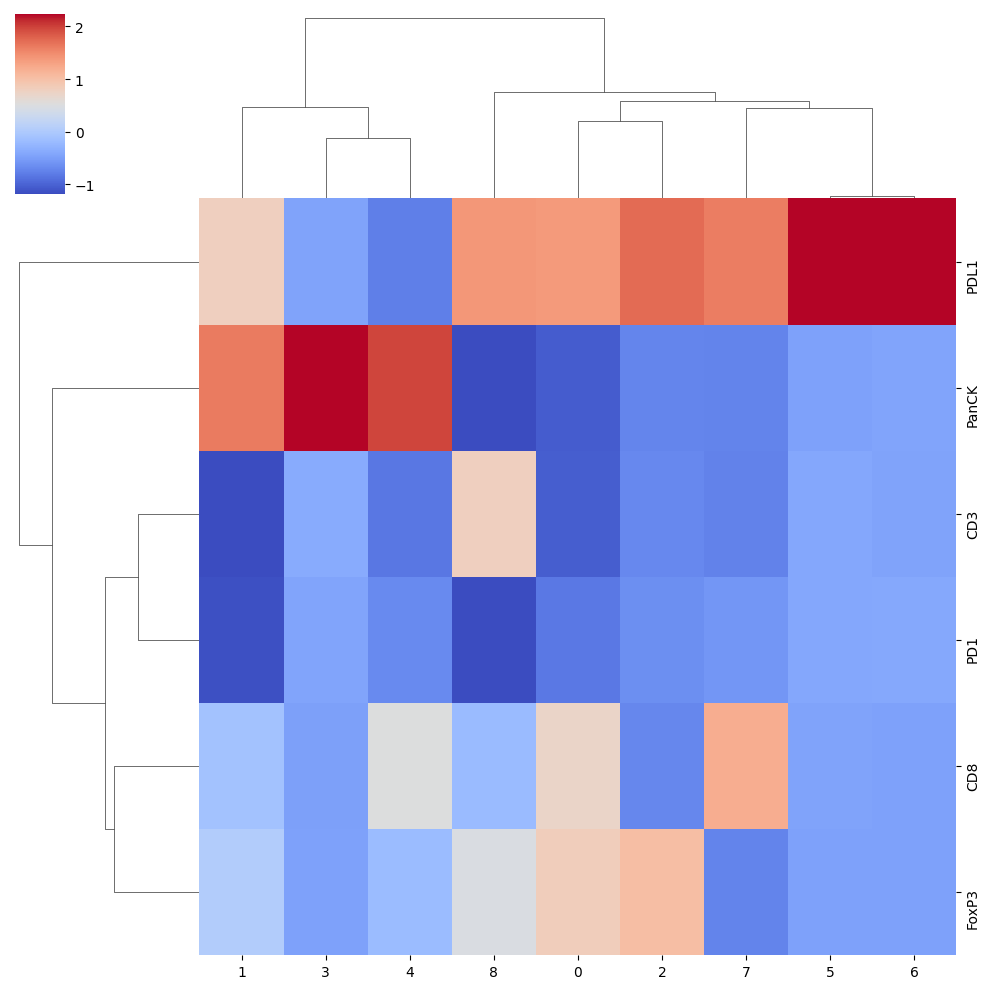

In [114]:


plt.figure(3000 ,dpi=dpi_set,figsize=(8,8))
#hm= sns.clustermap(np.transpose(zscore(cluster_stats,axis=0)),cmap='coolwarm',robust='True',xticklabels=yticks,yticklabels=y_marker,vmin= -1, vmax = 1)


hm= sns.clustermap(zscore(np.transpose(cluster_stats),axis=0),cmap='coolwarm', robust='True', xticklabels=yticks, yticklabels=y_marker)
    
    
file_name = os.path.join(path_figures+'Clustermap_zscored_1.png')
#file_name = os.path.join(path_c+'/Clustermap_unscaled.png')
plt.savefig(file_name,dpi='figure')
#plt.close()

marker_order = hm.data2d.index
cluster_order = hm.data2d.columns
cc = []
mc = []
#hm_z = zscore(hm.data2d,axis=0)
hm_z = np.array(hm.data2d)
for marker_i in range(len(y_marker)):
    mc.append(y_marker[marker_order[marker_i]])
    cc.append(np.array(cluster_order[np.array(np.where(hm_z[marker_i,:] > 0.0)).flatten()]))


In [41]:
cc

[array([1, 8, 0, 2, 7, 5, 6]),
 array([1, 3, 4]),
 array([8]),
 array([], dtype=int64),
 array([4, 0, 7]),
 array([1, 8, 0, 2])]

In [42]:
np.array(hm_z)[0,:]

array([ 0.79703594, -0.46112678, -0.77958646,  1.40111885,  1.37948904,
        1.73639906,  1.60602517,  2.23549965,  2.23556406])

In [43]:
cluster_order

Index([1, 3, 4, 8, 0, 2, 7, 5, 6], dtype='int64')

In [44]:
mc

['PDL1', 'PanCK', 'CD3', 'PD1', 'CD8', 'FoxP3']

In [45]:
(np.where(hm_z[5] > 0.5))

(array([4, 5]),)

#### Identify and Collect the tumour hulls

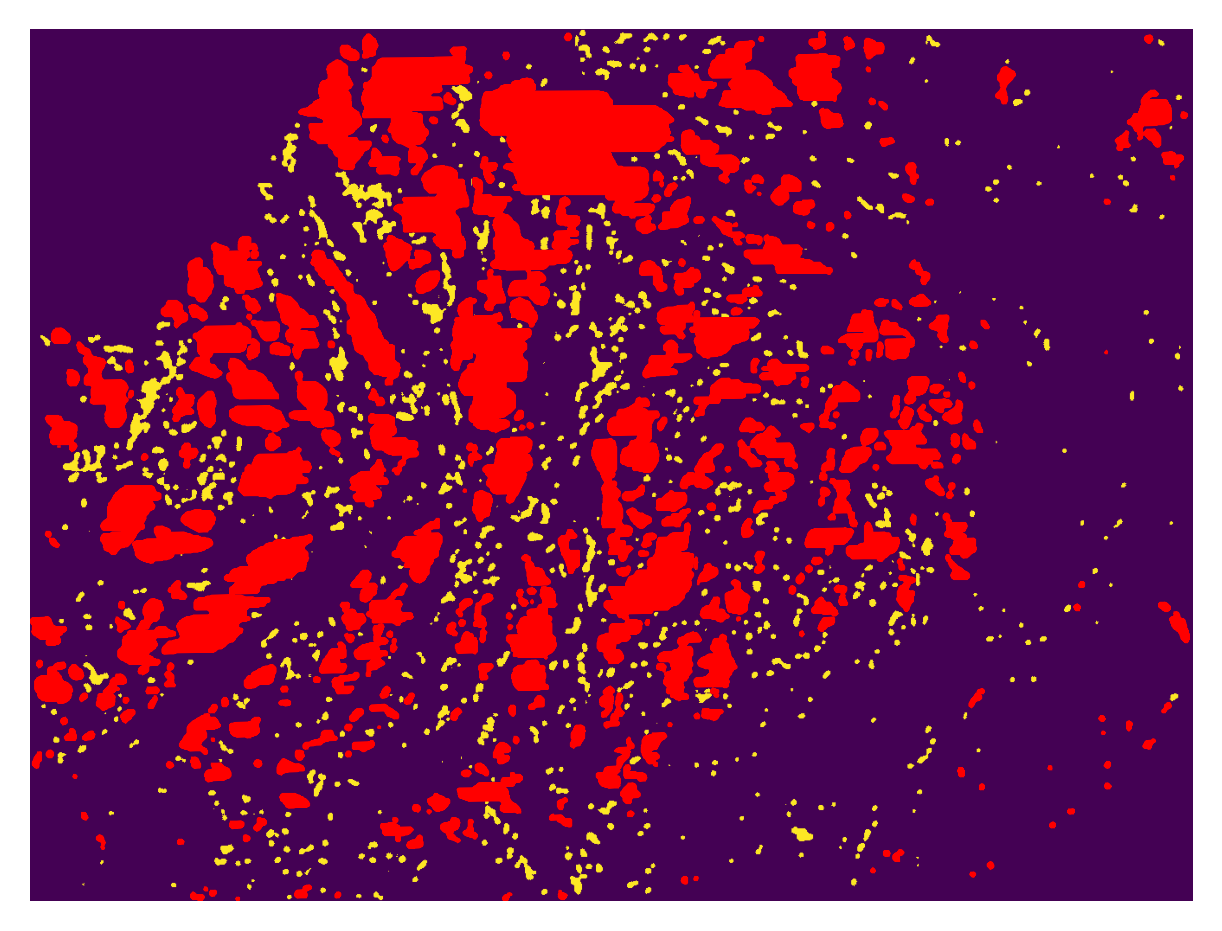

In [102]:


##plot the image with just tumour clusters and with hull
## do the Delauney once and get the hulls...switch it off to just collect the hulls

## 


stitched_image_4 = np.copy(stitched_image_1)

plt.figure(figsize=(5,5),dpi=300)
plt.imshow(stitched_image_4)
plt.axis('off')

hull_simplex = []
hulls = []

tumor_marker_1 = np.int64(np.array(np.where(np.char.find(mc, 'PanCK')==0)).flatten())
tumor_marker_1 = tumor_marker_1.astype(int)[0]
tumor_cluster = cc[tumor_marker_1]

for c_im, region in enumerate(regionprops(label_im_st)):
    if (cluster_asgn[c_im] in tumor_cluster): #[0,8,3,7]):
        #c=cm.colors[cluster_asgn[c_im]]
        #stitched_image_3[region.coords[:,0],region.coords[:,1]]=c#luster_asgn[c_im]
        ix_coord = np.array(region.coords[:,0])  # (256,)
        #print(ix_coord.shape)
        iy_coord = np.array(region.coords[:,1])  # (256,)
        #print(iy_coord.shape)
        #if (ix_coord.shape[0] > 3 and iy_coord.shape[0] > 3):
        f_image = np.vstack((ix_coord, iy_coord))  # (2, 256)
        #

        #axes.add_patch(Polygon(hull.simplices,closed=True, facecolor=cm.colors[cluster_asgn[c_im]]))
        f = np.transpose(f_image)     
        #plt.plot(f[:, 1], f[:, 0], color =cm.colors[cluster_asgn[c_im]],linewidth=2.5,fillstyle='full')
        plt.plot(f[:, 1], f[:, 0], color = 'red',linewidth=0.6,fillstyle='full')

        if (len(f) >= 5):
            if (len(set(f[:,0])) !=1):
                #hull = ConvexHull(np.array(f))
                hull = Delaunay(np.array(f))
                hulls.append(hull)
                hull_simplex.append(hull.simplices)
                '''
                for simplex in hull.simplices:
                    plt.plot(f[simplex, 1], f[simplex, 0], color =cm.colors[cluster_asgn[c_im]],linewidth=1.5,fillstyle='full')
                    #plt.plot(f[simplex, 1], f[simplex, 0], color ='red',linewidth=2.5,fillstyle='full')
                '''

   

#file_name = os.path.join(path_c+'/Image_tumour.png')
#plt.title("Tumour hulls")
#plt.savefig(file_name,dpi='figure')
#plt.close()


In [48]:
y_marker_immune= ['CD3', 'PD1', 'CD8', 'PDL1', 'FoxP3']


Colour the cells based on clustering results
CD3
[8]
Marker  CD3  expressed in cluster  8  has  49 cells within a tumour hull across  49 total number of cells in that cluster.
cc_count  49
cc_numcells  49
count_cells/numcells  1.0
cc_count_cells/cc_numcells  1.0
PD1
[]
CD8
[4 0 7]
Marker  CD8  expressed in cluster  4  has  0 cells within a tumour hull across  104 total number of cells in that cluster.
cc_count  0
cc_numcells  104
count_cells/numcells  0.0
cc_count_cells/cc_numcells  0.0
Marker  CD8  expressed in cluster  0  has  0 cells within a tumour hull across  328 total number of cells in that cluster.
cc_count  0
cc_numcells  432
count_cells/numcells  0.0
cc_count_cells/cc_numcells  0.0
Marker  CD8  expressed in cluster  7  has  0 cells within a tumour hull across  82 total number of cells in that cluster.
cc_count  0
cc_numcells  514
count_cells/numcells  0.0
cc_count_cells/cc_numcells  0.0
PDL1
[1 8 0 2 7 5 6]
Marker  PDL1  expressed in cluster  1  has  0 cells within a tumour 

Text(0.5, 1.0, 'Tumor immune')

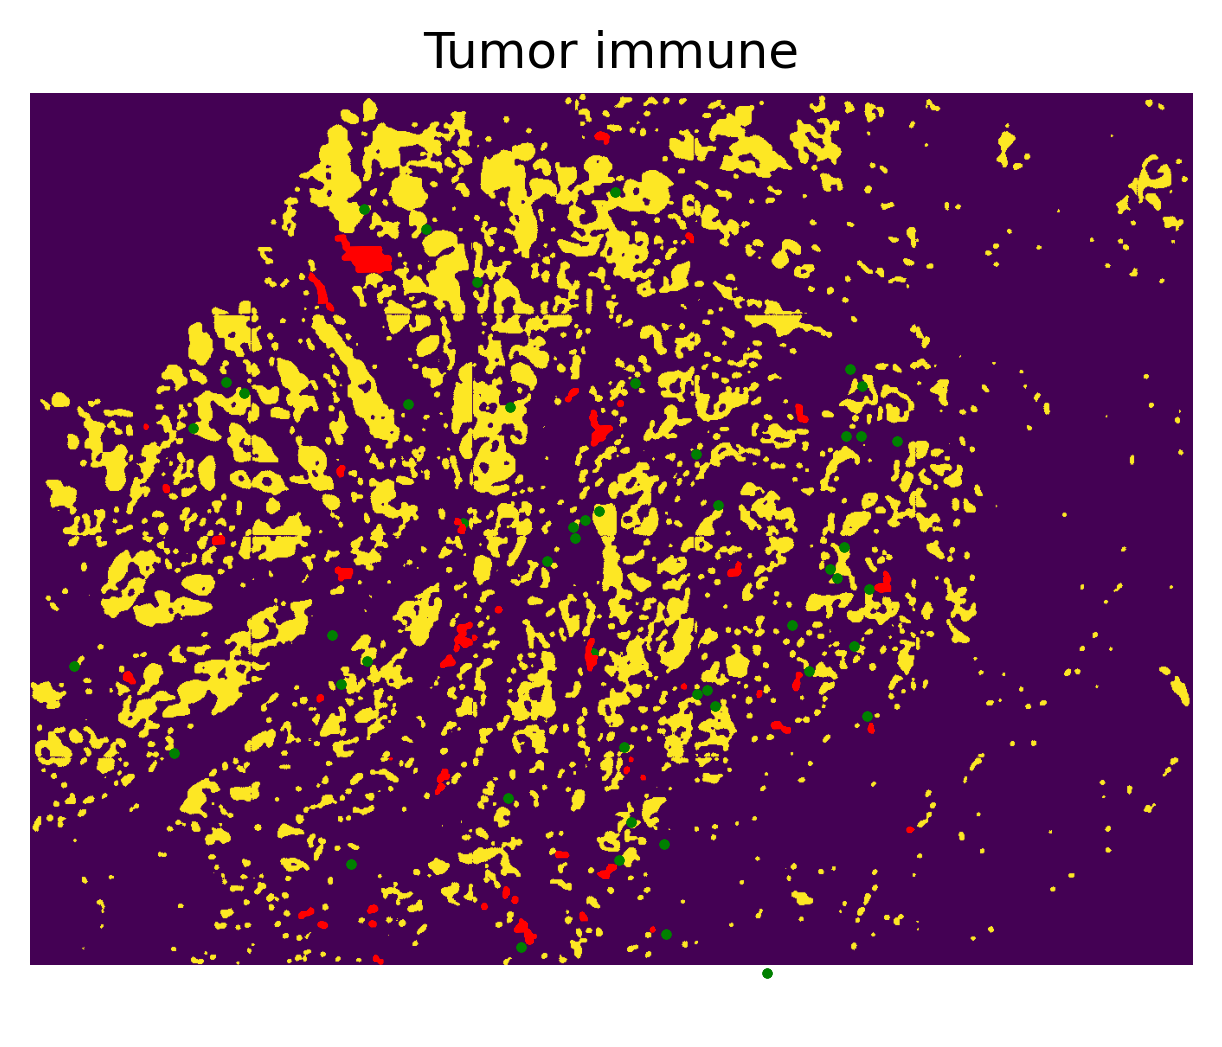

In [54]:
## collect the tumour hulls

##plot the image with just tumour clusters and with hull
## do the Delauney once and get the hulls...switch it off to just collect the hulls

## 
print('Colour the cells based on clustering results')


filew = open(os.path.join(path_python+'output/count_data/marker_cluster_spread.txt'),'a')


stitched_image_4 = np.copy(stitched_image_1)

plt.figure(200, figsize=(5,5),dpi=300)
plt.imshow(stitched_image_4)
plt.axis('off')

hull_simplex = []
hulls = []

tumor_marker_1 = np.int64(np.array(np.where(np.char.find(mc, 'CD3')==0)).flatten())
tumor_marker_1 = tumor_marker_1.astype(int)[0]
tumor_cluster = cc[tumor_marker_1]

for c_im, region in enumerate(regionprops(label_im_st)):
    if (cluster_asgn[c_im] in tumor_cluster): #[0,8,3,7]):
        #c=cm.colors[cluster_asgn[c_im]]
        #stitched_image_3[region.coords[:,0],region.coords[:,1]]=c#luster_asgn[c_im]
        ix_coord = np.array(region.coords[:,0])  # (256,)
        #print(ix_coord.shape)
        iy_coord = np.array(region.coords[:,1])  # (256,)
        #print(iy_coord.shape)
        #if (ix_coord.shape[0] > 3 and iy_coord.shape[0] > 3):
        f_image = np.vstack((ix_coord, iy_coord))  # (2, 256)
        #

        #axes.add_patch(Polygon(hull.simplices,closed=True, facecolor=cm.colors[cluster_asgn[c_im]]))
        f = np.transpose(f_image)     
        #plt.plot(f[:, 1], f[:, 0], color =cm.colors[cluster_asgn[c_im]],linewidth=2.5,fillstyle='full')
        plt.plot(f[:, 1], f[:, 0], color = 'red',linewidth=0.5,fillstyle='full')

        if (len(f) >= 5):
            if (len(set(f[:,0])) !=1):
                #hull = ConvexHull(np.array(f))
                hull = Delaunay(np.array(f))
                hulls.append(hull)
                hull_simplex.append(hull.simplices)
                '''
                for simplex in hull.simplices:
                    plt.plot(f[simplex, 1], f[simplex, 0], color =cm.colors[cluster_asgn[c_im]],linewidth=1.5,fillstyle='full')
                    #plt.plot(f[simplex, 1], f[simplex, 0], color ='red',linewidth=2.5,fillstyle='full')
                '''

   

#file_name = os.path.join(path_c+'/Image_color_tSNE_tumour.png')
#plt.title("Coloured_tSNE")
#plt.savefig(file_name,dpi='figure')
#plt.close()


## since tumour cells are bigger, we can start by checking which immune cells overlap (or are within) the tumour cells. 
## For this we have the hulls
## for each immune marker and its cluster
### get cells and for each tumor hull, check if each cell is inside or outside, plot the immunce cell centroid on the image (for diagnostics purpose for now)

#stitched_image_5 = np.copy(stitched_image_1)

#plt.figure(100, figsize=(10,10),dpi=300)
#plt.imshow(stitched_image_5)
#plt.axis('off')

frac = []

for mm in range(len(y_marker_immune)):
    immune_marker_1 = np.int64(np.array(np.where(np.char.find(mc, y_marker_immune[mm])==0)).flatten())
    immune_marker_1 = immune_marker_1.astype(int)[0]
    print(y_marker_immune[mm])
    immune_cluster = cc[immune_marker_1]
    print(immune_cluster)
    
    cc_count = 0
    cc_numcells = 0
    # for each immune cluster that immune marker represents
    for m in range(len(immune_cluster)):
        count_cells = 0
        numcells = counts[immune_cluster[m]]
        cell_ids = np.array(np.where(cluster_asgn==immune_cluster[m])).flatten()
        for n in range(numcells):
            cell_cent = cent[cell_ids[n]]
            cell_cent = np.round(np.array(cell_cent),1)
            #point = Point(cell_cent)
            point = cell_cent
            #plt.plot(cell_cent[0],cell_cent[1],color='red',fillstyle='full', markersize=2)
            
            for h in range(len(hull_simplex)):
                #check if the point in within the hull, if yes, note and break, else mark as in stroma
                #if (hull_simplex[h].find_simplex(point)>=0):
                if (hulls[h].find_simplex(point)>=0):
                    #print('true')
                    #print(point)
                    #print(hull_simplex[h])
                    plt.figure(200)#, figsize=(5,5),dpi=300)
                    #plt.plot(cell_cent[0],cell_cent[1],color='red',fillstyle='full', markersize=2)
                    plt.scatter(cent[cell_ids[n]][0],cent[cell_ids[n]][1],color='green',s=2)
                    count_cells = count_cells + 1
        print('Marker ',y_marker_immune[mm],' expressed in cluster ',immune_cluster[m],' has ',count_cells,  'cells within a tumour hull across ',numcells,'total number of cells in that cluster.')
        #print(numcells)
        cc_count = cc_count + count_cells
        cc_numcells = cc_numcells + numcells
        print('cc_count ', cc_count)
        print('cc_numcells ',cc_numcells)
        print('count_cells/numcells ', count_cells/numcells)
        print('cc_count_cells/cc_numcells ', cc_count/cc_numcells)
        
        
        '''
        #filew.write('hello world \n')
        filew.write(print('Marker ',y_marker_immune[mm],' expressed in cluster ',immune_cluster[m],' has ',count_cells,  'cells within a tumour hull across ',numcells,'total number of cells in that cluster. \n'))
        #print(numcells)
        filew.write('cc_count \n', cc_count)
        filew.write('cc_numcells \n',cc_numcells)
        filew.write('count_cells/numcells \n ', count_cells/numcells)
        filew.write('cc_count_cells/cc_numcells \n', cc_count/cc_numcells)
        '''
        

    if cc_numcells!=0:
        frac.append(cc_count/cc_numcells)
    else:
        frac.append(0)
filew.close()
#plt.close()

#file_name = os.path.join(path_c+'/Image_tumour_immune_within.png')
plt.title("Tumor immune")
#plt.savefig(file_name,dpi='figure')
#plt.close()

Colour the cells based on clustering results


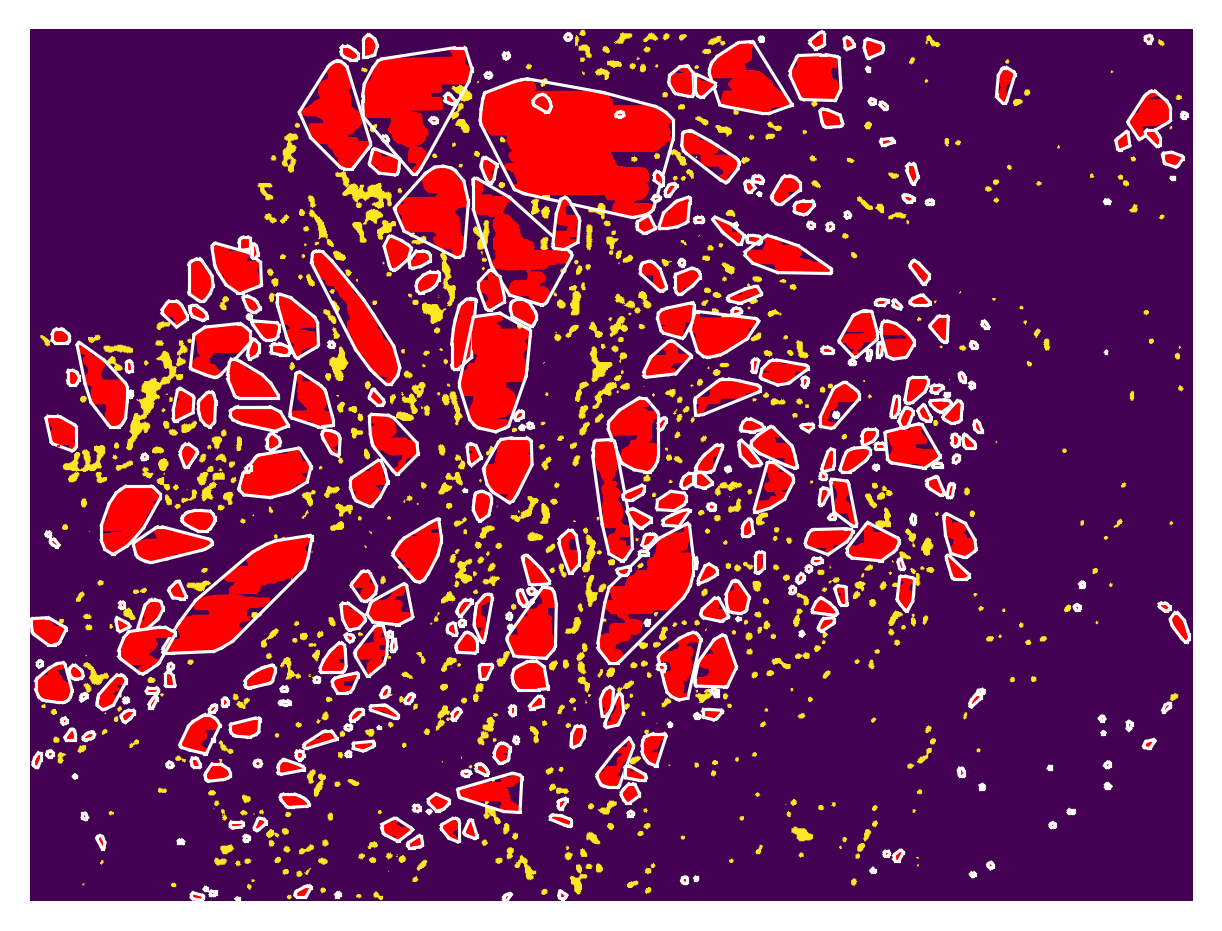

In [55]:
# Plot the image with just tumour clusters and with hull

from scipy.spatial import Delaunay
## 
print('Colour the cells based on clustering results')


stitched_image_4 = np.copy(stitched_image_1)

plt.figure(figsize=(5,5),dpi=300)
plt.imshow(stitched_image_4)
plt.axis('off')

tumor_marker_1 = np.int64(np.array(np.where(np.char.find(mc, 'PanCK')==0)).flatten())
tumor_marker_1 = tumor_marker_1.astype(int)[0]
tumor_cluster = cc[tumor_marker_1]


for c_im, region in enumerate(regionprops(label_im_st)):
    
    if (cluster_asgn[c_im] in tumor_cluster): #[12, 15, 13, 14, 11,  1,  3,  5]): #][0,8,3,7]):
        #c=cm.colors[cluster_asgn[c_im]]
        #stitched_image_3[region.coords[:,0],region.coords[:,1]]=c#luster_asgn[c_im]
        ix_coord = np.array(region.coords[:,0])  # (256,)
        #print(ix_coord.shape)
        iy_coord = np.array(region.coords[:,1])  # (256,)
        #print(iy_coord.shape)
        #if (ix_coord.shape[0] > 3 and iy_coord.shape[0] > 3):
        f_image = np.vstack((ix_coord, iy_coord))  # (2, 256)
        #

        #axes.add_patch(Polygon(hull.simplices,closed=True, facecolor=cm.colors[cluster_asgn[c_im]]))
        f = np.transpose(f_image)     
        #plt.plot(f[:, 1], f[:, 0], color =cm.colors[cluster_asgn[c_im]],linewidth=2.5,fillstyle='full')
        plt.plot(f[:, 1], f[:, 0], color = 'red',linewidth=0.5,fillstyle='full')

        if (len(f) >= 5):
            if (len(set(f[:,0])) !=1):
                hull = ConvexHull(np.array(f))
                #hull = Delaunay(np.array(f))
                for simplex in hull.simplices:
                    #plt.plot(f[simplex, 1], f[simplex, 0], color =cm.colors[cluster_asgn[c_im]],linewidth=0.75,fillstyle='full')
                    plt.plot(f[simplex, 1], f[simplex, 0], color ='white',linewidth=0.75,fillstyle='full')
                    #plt.plot(f[simplex, 1], f[simplex, 0], color ='red',linewidth=2.5,fillstyle='full')


   

#file_name = os.path.join(path_c+'/Image_color_tSNE_tumour.png')
#plt.title("Coloured_tSNE")
#plt.savefig(file_name,dpi='figure')
#plt.close()






number of tumor regions: 365


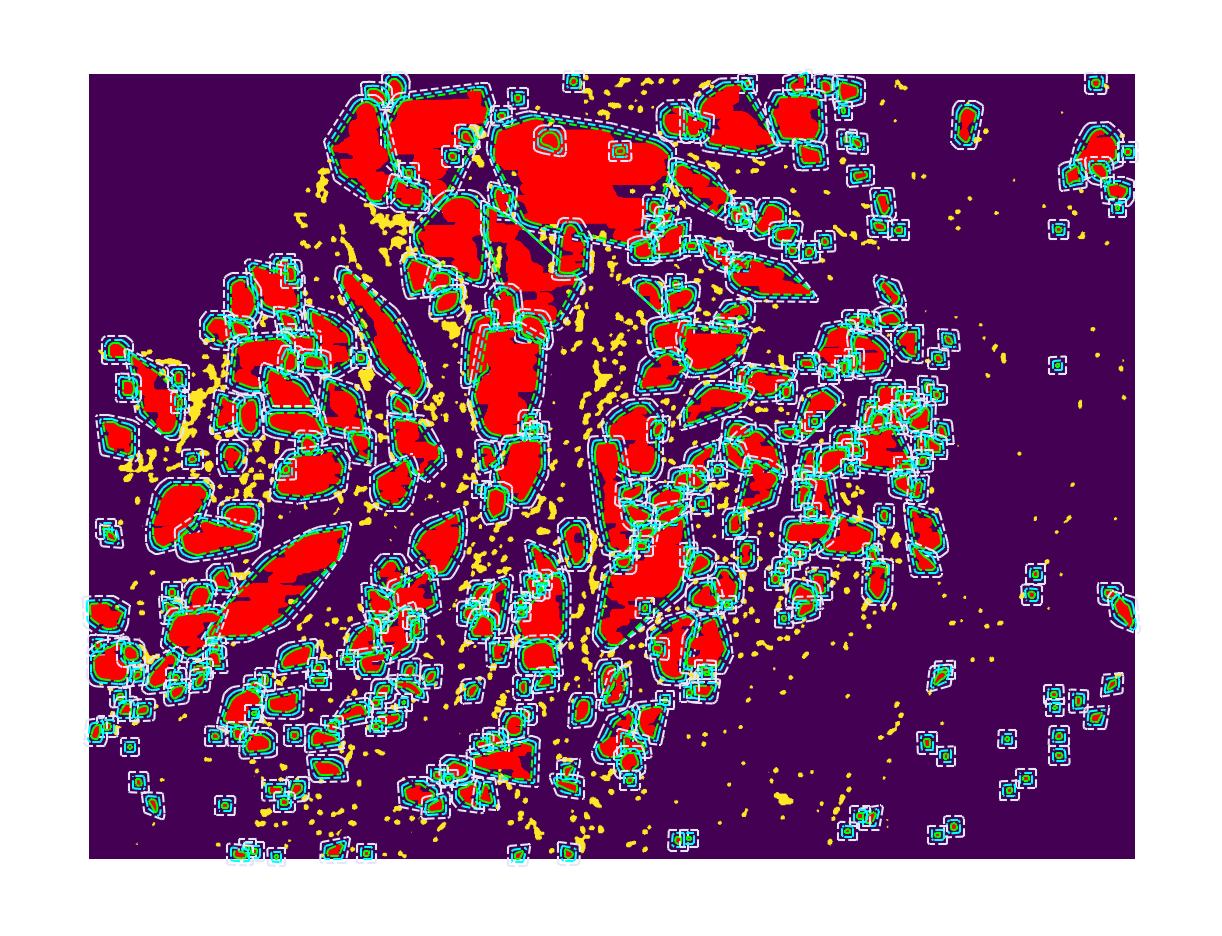

In [130]:
## Code for hull expansion 
## Works with multiple boundaries within outer boundary (g)
## with density vector creation
# plot the image with just tumour clusters and with hull

from scipy.spatial import Delaunay
## 


boundary_width = 10
stitched_image_4 = np.copy(stitched_image_1)

plt.figure(figsize=(5,5),dpi=300)
plt.imshow(stitched_image_4)
plt.axis('off')

hull_simplex = []
hulls = []


hull_simplex_o = []
hulls_o = []

tumor_marker_1 = np.int64(np.array(np.where(np.char.find(mc, 'PanCK')==0)).flatten())
tumor_marker_1 = tumor_marker_1.astype(int)[0]
tumor_cluster = cc[tumor_marker_1]


counta = 0

region_cell = []
region_area_1 = []
boundary_CM_list = []


region_00 = []
region_bwbw = []
region_55 = []
region_11 = []

for c_im, region in enumerate(regionprops(label_im_st)):
    
    if ((cluster_asgn[c_im] in tumor_cluster)):#& (counta <= 25)): #[12, 15, 13, 14, 11,  1,  3,  5]): #][0,8,3,7]):
        #print(counta)
        #c=cm.colors[cluster_asgn[c_im]]
        #stitched_image_3[region.coords[:,0],region.coords[:,1]]=c#luster_asgn[c_im]
        ix_coord = np.array(region.coords[:,0])  # (256,)
        #print(ix_coord.shape)
        iy_coord = np.array(region.coords[:,1])  # (256,)
        #print(iy_coord.shape)
        #if (ix_coord.shape[0] > 3 and iy_coord.shape[0] > 3):
        f_image = np.vstack((ix_coord, iy_coord))  # (2, 256)
        #

        #axes.add_patch(Polygon(hull.simplices,closed=True, facecolor=cm.colors[cluster_asgn[c_im]]))
        
        f = np.transpose(f_image)  
        cX = sum(f[:,0]) / f.shape[0]
        cY = sum(f[:,1]) / f.shape[0]

        g = np.copy(f)
        h = np.copy(f)
        j = np.copy(f)

        #CoM_stage_coords[i, 0] = cX
        #CoM_stage_coords[i, 1] = cY

        for i in range(f.shape[0]):
            if (f[i,0] <=cX):
                g[i,0] = f[i,0] - boundary_width
                h[i,0] = f[i,0] - 5
                j[i,0] = f[i,0] - 1
            else:
                g[i,0] = f[i,0] + boundary_width
                h[i,0] = f[i,0] +  5
                j[i,0] = f[i,0] +  1
            if (f[i,1] <=cY):
                g[i,1] = f[i,1] - boundary_width
                h[i,1] = f[i,1] - 5
                j[i,1] = f[i,1] - 1
            else:
                g[i,1] = f[i,1] + boundary_width
                h[i,1] = f[i,1] + 5
                j[i,1] = f[i,1] + 1
                
                
        #####
        ## building the density vector

        region_cell_temp = np.zeros(num_frames-1)
        #cent.append(region.centroid)
        region_0 = np.zeros(num_frames-1)
        region_bw = np.zeros(num_frames-1)
        region_5 = np.zeros(num_frames-1)
        region_1 = np.zeros(num_frames-1)

        region_area_1.append(f.shape[0])

        for marker in range(num_frames-1):
            val0 = 0
            valbw = 0
            val5 = 0
            val1 = 0
            val = 0
            for a in range(f.shape[0]):
                #val = im[marker][region.coords[a][0],region.coords[a][1]]+val
                if(im[marker][f[a][0],f[a][1]] >= thresh_m[marker]):
                    val0 = val0 + 1
                    val = val + 1
                if (g[a][0] < 1008):
                    if (g[a][0] < (im.shape[1]) | g[a][1] < (im.shape[2])):
                        if(im[marker][g[a][0],g[a][1]] >= thresh_m[marker]):
                            valbw = valbw + 1
                            val = val + 1
                if (h[a][0] < 1008):
                    if (h[a][0] < (im.shape[1]) | h[a][1] < (im.shape[2])):
                        if(im[marker][h[a][0],h[a][1]] >= thresh_m[marker]):
                            val5 = val5 + 1
                            val = val + 1
                if (j[a][0] < 1008):
                    if (j[a][0] < (im.shape[1]) | j[a][1] < (im.shape[2])):
                        if(im[marker][j[a][0],j[a][1]] >= thresh_m[marker]):
                            val1 = val1 + 1
                            val = val + 1
            region_cell_temp[marker]=val
            
            region_0[marker] = val0
            region_bw[marker] = valbw
            region_5[marker] = val5
            region_1[marker] = val1
            
        region_cell.append(region_cell_temp/f.shape[0])
        
        region_00.append(region_0/f.shape[0])
        region_bwbw.append(region_bw/f.shape[0])
        region_55.append(region_5/f.shape[0])
        region_11.append(region_1/f.shape[0])

        

        ####
        ####

        #plt.plot(f[:, 1], f[:, 0], color =cm.colors[cluster_asgn[c_im]],linewidth=2.5,fillstyle='full')
        plt.plot(f[:, 1], f[:, 0], color = 'red',linewidth=0.5,fillstyle='full')

        if (len(f) >= 5):
            if (len(set(f[:,0])) !=1):
                #hull = ConvexHull(np.array(f))
                #hull = Delaunay(np.array(f))
                #for simplex in hull.simplices:
                    #plt.plot(f[simplex, 1], f[simplex, 0], color =cm.colors[cluster_asgn[c_im]],linewidth=1,fillstyle='full')
                #    plt.plot(f[simplex, 1], f[simplex, 0], color ='red',linewidth=0.5,fillstyle='full')

                hull_o = ConvexHull(np.array(g))
                #hull = Delaunay(np.array(f))
                for simplex in hull_o.simplices:
                    plt.plot(g[simplex, 1], g[simplex, 0], color ='lavender',linewidth=0.5,fillstyle='full',linestyle='dashed')
                    plt.plot(h[simplex, 1], h[simplex, 0], color ='cyan',linewidth=0.5,fillstyle='full',linestyle='dashed')
                    plt.plot(j[simplex, 1], j[simplex, 0], color ='lime',linewidth=0.5,fillstyle='full',linestyle='dashed')
                    #plt.plot(f[simplex, 1], f[simplex, 0], color ='red',linewidth=2.5,fillstyle='full')

                '''hull_o = ConvexHull(np.array(h))
                #hull = Delaunay(np.array(f))
                for simplex in hull_o.simplices:
                    plt.plot(h[simplex, 1], h[simplex, 0], color ='yellow',linewidth=0.5,fillstyle='full')
                    #plt.plot(f[simplex, 1], f[simplex, 0], color ='red',linewidth=2.5,fillstyle='full')
                '''
        counta = counta + 1
        
boundary_CM_list.append(np.array(region_cell))
        
print("number of tumor regions: "+str(counta))
#file_name = os.path.join(path_c+'/Boundary_tumour_2.png')
#plt.title("Coloured_tSNE")
#plt.savefig(file_name,dpi='figure')
#plt.close()






#### Morisita horn 

In [64]:
mean_area_bc = np.int64(np.mean(region_area))
print(mean_area_bc)

190


In [ ]:
#cluster_stats = np.zeros([len(target_ids),num_frames-1], dtype=float)
#yticks = np.array(target_ids)

# Checks
# the number of cells per cluster
region_area_new_all = []

region_coords_new_all = []

region_cell_new_all = []

for k in target_ids:
    
    region_area_new = []
    region_coords_new = []
    region_cell_new = []
    
    print('********cluster *******')
    print(k)
    #yticks[k] = int(k)
    cell_rows = np.array(np.where(cluster_asgn == (k))).flatten()
    
    #cluster_stats[k,:] = M[cell_rows,:].sum(axis=0,keepdims=True)
    l_bc = len(cell_rows)
    region_cell_temp_new = np.zeros(num_frames-1)

    for bc in range(l_bc):
        print('big cell', str(bc))

        j =  regionprops(label_im_st)[cell_rows[bc]]
        num_split = np.int64(region_area[cell_rows[bc]]/mean_area_bc)
        num_split_rem = region_area[cell_rows[bc]]%mean_area_bc

        print('number split',str(num_split))
        print('area is', str(region_area[cell_rows[bc]]))
        
        if (num_split != 0):
            for n in range(num_split):
                sn = range(mean_area_bc*n,mean_area_bc*(n+1))
                #print('range is', str(sn))
                #print('num_split',str(n))

                
                for marker in range(num_frames-1):
                    val = 0
                    for a in sn: #range(region_area[big_cell_ids[bc]]):
                        #val = im[marker][region.coords[a][0],region.coords[a][1]]+val
                        if(im[marker][j.coords[a][0],j.coords[a][1]] >= thresh_m[marker]):
                            val = val + 1
                    region_cell_temp_new[marker]=val

                region_cell_new.append(region_cell_temp_new/mean_area_bc)
                
                region_coords_new.append(j.coords[sn,:])
                region_area_new.append(len(j.coords[sn,:]))

            if (num_split_rem!= 0):
                sn = range(mean_area_bc*(n+1),mean_area_bc*(n+1)+num_split_rem)
                #print('range is', str(sn))
                #print('num_split',str(n))

                
                for marker in range(num_frames-1):
                    val = 0
                    for a in sn: #range(region_area[big_cell_ids[bc]]):
                        #val = im[marker][region.coords[a][0],region.coords[a][1]]+val
                        if(im[marker][j.coords[a][0],j.coords[a][1]] >= thresh_m[marker]):
                            val = val + 1
                    region_cell_temp_new[marker]=val
                region_cell_new.append(region_cell_temp_new/len(j.coords[sn,:]))
                
                region_coords_new.append(j.coords[sn,:])
                region_area_new.append(len(j.coords[sn,:]))  

        else:
            region_coords_new.append(j.coords)
            region_area_new.append(j.area)
            if cell_rows[bc]<len(region_cell): ## added may 2025
                region_cell_new.append(region_cell[cell_rows[bc]])
            else:
                region_cell_new.append(0)

            
    region_cell_new_all.append(region_cell_new)        
    region_coords_new_all.append(region_coords_new)
    region_area_new_all.append(region_area_new)

In [66]:
num_cells_new = 0
for k in target_ids:
    num_cells_new = len(region_area_new_all[k]) + num_cells_new

print(num_cells_new)


1971


In [121]:
# for each marker: for all the clusters of that marker, go through each cell and colour the cell
# this is to colour marker region wise

print('Colour the cells based on marker regions')

sum_num_cells_marker_all = []
cell_abund_score = []

stitched_image_4 = np.copy(stitched_image_1)


'''
plt.figure(figsize=(5,5),dpi=300)
plt.imshow(stitched_image_4)
plt.axis('off')
'''
hull_simplex = []
hulls = []

#tumor_marker_1 = np.int(np.array(np.where(np.char.find(mc, 'PanCK')==0)).flatten())
for m_ind in range(0,6):
    
    '''
    plt.figure(figsize=(5,5),dpi=300)
    plt.imshow(stitched_image_4)
    plt.axis('off')
    '''
    marker_1 = np.int64(np.array(np.where(np.char.find(mc, mc[m_ind])==0)).flatten())
    marker_1 = marker_1.astype(int)
    marker_cluster = cc[marker_1[0]]
    print(mc[m_ind])
    for c_im, region in enumerate(regionprops(label_im_st)):
        if (cluster_asgn[c_im] in marker_cluster): #[0,8,3,7]):
            #c=cm.colors[cluster_asgn[c_im]]
            #stitched_image_3[region.coords[:,0],region.coords[:,1]]=c#luster_asgn[c_im]
            ix_coord = np.array(region.coords[:,0])  # (256,)
            #print(ix_coord.shape)
            iy_coord = np.array(region.coords[:,1])  # (256,)
            #print(iy_coord.shape)
            #if (ix_coord.shape[0] > 3 and iy_coord.shape[0] > 3):
            f_image = np.vstack((ix_coord, iy_coord))  # (2, 256)
            #

            #axes.add_patch(Polygon(hull.simplices,closed=True, facecolor=cm.colors[cluster_asgn[c_im]]))
            f = np.transpose(f_image)  
            
            #plt.plot(f[:, 1], f[:, 0], color =cm.colors[cluster_asgn[c_im]],linewidth=2.5,fillstyle='full')
            #plt.plot(f[:, 1], f[:, 0], color =cm.colors[cluster_asgn[c_im]],linewidth=0.6,fillstyle='full')

            '''
            if (len(f) >= 5):
                if (len(set(f[:,0])) !=1):
                    hull = ConvexHull(np.array(f))
                    #hull = Delaunay(np.array(f))
                    hulls.append(hull)
                    hull_simplex.append(hull.simplices)

            '''

    #file_name = os.path.join(path_figures+'Image_'+str(mc[m_ind])+'.png')
    #plt.title("Marker " + str(mc[m_ind])+ " hulls")
    #plt.savefig(file_name,dpi='figure')
    
    #plt.close()

    sum_num_cells_marker = 0 
    for kl in range(len(marker_cluster)):
        sum_num_cells_marker = sum_num_cells_marker + len(region_area_new_all[marker_cluster[kl]])
    print(sum_num_cells_marker) 
    sum_num_cells_marker_all.append(sum_num_cells_marker)
    print('cell abundance score')
    print(sum_num_cells_marker/num_cells_new)
    cell_abund_score.append(sum_num_cells_marker/num_cells_new)
    
    


Colour the cells based on marker regions
PDL1
1605
cell abundance score
0.8143074581430746
PanCK
1129
cell abundance score
0.5728056823947235
CD3
62
cell abundance score
0.03145611364789447
PD1
0
cell abundance score
0.0
CD8
681
cell abundance score
0.3455098934550989
FoxP3
1346
cell abundance score
0.6829020801623541


In [69]:
lymphocyte_cells = ['CD8','CD3','FoxP3']

In [70]:
image_marker_order = ['CD3', 'PD1', 'CD8', 'PDL1', 'FoxP3', 'PanCK']#, 'DAPI']

sum_num_cells_marker = []
cell_abund_score_1 = []
    
for p in range(len(image_marker_order)):
    marker_1 = np.int64(np.array(np.where(np.char.find(mc, image_marker_order[p])==0)).flatten())
    print(image_marker_order[p])
    #print(sum_num_cells_marker_all[marker_1][0])  #[0] on may 2025
    #print(cell_abund_score[marker_1]) 

    
    cell_abund_score_1.append(cell_abund_score[marker_1[0]])
    sum_num_cells_marker.append(sum_num_cells_marker_all[marker_1[0]])


CD3
PD1
CD8
PDL1
FoxP3
PanCK


In [122]:
for p in range(len(lymphocyte_cells)):
    marker_1 = np.int64(np.array(np.where(np.char.find(mc, lymphocyte_cells[p])==0)).flatten())
    print(lymphocyte_cells[p])
    print(sum_num_cells_marker_all[marker_1[0]]) #[0] added in may 2025
    print(cell_abund_score[marker_1[0]]) 

CD8
681
0.3455098934550989
CD3
62
0.03145611364789447
FoxP3
1346
0.6829020801623541


In [109]:
#image_marker_order = ['CD3', 'PD1', 'CD8', 'PDL1', 'FoxP3', 'PanCK', 'DAPI']
#lymphocyte_choice = [0,2,4]

intra_tumor_all = []
intra_lymph_infil_all = []
Morisita_Horn_overlap_all = []

for l in range(len(lymphocyte_cells)):
    intra_tumor = []
    intra_lymph_infil = []
    Morisita_Horn_overlap_within = []
    Morisita_Horn_overlap_outside = []
    
    print(lymphocyte_cells[l])
    marker_1 = np.int64(np.array(np.where(np.char.find(mc, lymphocyte_cells[l])==0)).flatten())#clustering based
    overlap_clusters = np.intersect1d(cc[marker_1[0]] , tumor_cluster)
    marker_2 = np.int64(np.array(np.where(np.char.find(image_marker_order, lymphocyte_cells[l])==0)).flatten())#image_tiff order
    
    marker_2_panck = np.int64(np.array(np.where(np.char.find(image_marker_order, 'PanCK')==0)).flatten())
    
    if (len(overlap_clusters)!=0):# meaning there is some clusters overlapping
        sum_infil = 0
        sum_tum = 0
        for o in range(len(overlap_clusters)):
            print('overlap cluster')
            print(o)
            #print(sum_num_cells_marker_all[overlap_clusters[o]]) 
            #print(cell_abund_score[overlap_clusters[o]])
            
            l_over = np.sum(np.array(region_cell_new_all[o],dtype=object)[marker_2])/len(region_area_new_all[o])
            t_over = np.sum(np.array(region_cell_new_all[o],dtype=object)[marker_2_panck])/len(region_area_new_all[o])
            if (np.power(l_over,2).any!=0):
                s = np.power(l_over,2) + np.power(t_over,2)
                s[np.where(s==0)]=0.00000001  
                #Morisita_Horn_overlap = 2*l_over*t_over/(np.power(l_over,2) + np.power(t_over,2))
                Morisita_Horn_overlap = 2*l_over*t_over/s
            else:
                Morisita_Horn_overlap = 0
            print(Morisita_Horn_overlap)
            print(t_over)
            print(l_over)
            Morisita_Horn_overlap = np.nan_to_num(Morisita_Horn_overlap, nan=0)
            Morisita_Horn_overlap_within.append(Morisita_Horn_overlap)
            
            sum_infil = sum_infil + l_over #np.sum(np.array(region_cell_new_all[o])[:,marker_2])/len(region_area_new_all[o])
            sum_tum = sum_tum + t_over #np.sum(np.array(region_cell_new_all[o])[:,marker_2_panck])/len(region_area_new_all[o])
    
        intra_tumor.append(sum_tum)
        intra_lymph_infil.append(sum_infil)
        Morisita_Horn_overlap_outside.append(Morisita_Horn_overlap_within)
        
    intra_tumor_all.append(intra_tumor)
    intra_lymph_infil_all.append(intra_lymph_infil)    
    Morisita_Horn_overlap_all.append(Morisita_Horn_overlap_outside)

CD8
overlap cluster
0
[0.         0.         0.         0.         0.         0.95556353
 0.        ]
[7.87065147e-05 1.63971906e-04 2.38508849e-03 4.24687235e-03
 1.40406800e-03 3.50384538e-03 0.00000000e+00]
[0.         0.         0.         0.         0.         0.00258587
 0.        ]
CD3
FoxP3
overlap cluster
0
[0.20367887 0.91783901 0.82166228 0.31982246 0.76158831 0.77934557
 0.        ]
[7.87065147e-05 1.63971906e-04 2.38508849e-03 4.24687235e-03
 1.40406800e-03 3.50384538e-03 0.00000000e+00]
[8.10032742e-06 1.07734355e-04 1.24826045e-03 6.97438190e-04
 6.48836226e-04 7.31297559e-03 1.62006548e-06]


In [110]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
X = region_coords_new_all[1][0]#np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [111]:
## weighted Morisita Horn measure

image_marker_order = ['CD3', 'PD1', 'CD8', 'PDL1', 'FoxP3', 'PanCK']#, 'DAPI']
#lymphocyte_choice = [0,2,4]

intra_tumor_all_wMH = []
intra_lymph_infil_all_wMH = []
Morisita_Horn_overlap_all_wMH = []

for l in range(len(lymphocyte_cells)):
    intra_tumor_wMH = []
    intra_lymph_infil_wMH = []
    Morisita_Horn_overlap_within_wMH = []
    Morisita_Horn_overlap_outside_wMH = []
    
    print(lymphocyte_cells[l])
    marker_1_wMH = np.int64(np.array(np.where(np.char.find(mc, lymphocyte_cells[l])==0)).flatten())#clustering based
    overlap_clusters_wMH = np.intersect1d(cc[marker_1[0]] , tumor_cluster)
    marker_2_wMH = np.int64(np.array(np.where(np.char.find(image_marker_order, lymphocyte_cells[l])==0)).flatten())#image_tiff order
    
    marker_2_panck_wMH = np.int64(np.array(np.where(np.char.find(image_marker_order, 'PanCK')==0)).flatten())
    
    if (len(overlap_clusters_wMH)!=0):# meaning there is some clusters overlapping
        sum_infil = 0
        sum_tum = 0
        for o in range(len(overlap_clusters_wMH)):
            print('overlap cluster')
            print(o)
            #print(sum_num_cells_marker_all[overlap_clusters[o]]) 
            #print(cell_abund_score[overlap_clusters[o]])
            
            ### find knn using ball tree method
            X = region_coords_new_all[o][0]#np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
            nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X)
            distances, indices = nbrs.kneighbors(X)
            
            ### for each cell for n_cell in range(len(region_area_new_all[o]))
            
            
            
            
            l_over_wMH = np.sum(np.array(region_cell_new_all[o],dtype=object)[marker_2])/len(region_area_new_all[o])
            t_over_wMH = np.sum(np.array(region_cell_new_all[o],dtype=object)[marker_2_panck])/len(region_area_new_all[o])
            Morisita_Horn_overlap_wMH = 2*l_over_wMH*t_over_wMH/(np.power(l_over_wMH,2) + np.power(t_over_wMH,2))
            print(Morisita_Horn_overlap_wMH)
            Morisita_Horn_overlap_within_wMH.append(Morisita_Horn_overlap_wMH)
            
            sum_infil = sum_infil + np.sum(np.array(region_cell_new_all[o],dtype=object)[marker_2_wMH])/len(region_area_new_all[o])
            sum_tum = sum_tum + np.sum(np.array(region_cell_new_all[o],dtype=object)[marker_2_panck_wMH])/len(region_area_new_all[o])
    
        intra_tumor_wMH.append(sum_tum)
        intra_lymph_infil_wMH.append(sum_infil)
        Morisita_Horn_overlap_outside_wMH.append(Morisita_Horn_overlap_within_wMH)
        
    intra_tumor_all_wMH.append(intra_tumor_wMH)
    intra_lymph_infil_all_wMH.append(intra_lymph_infil_wMH)    
    Morisita_Horn_overlap_all_wMH.append(Morisita_Horn_overlap_outside_wMH)

CD8
overlap cluster
0
[0.20367887 0.91783901 0.82166228 0.31982246 0.76158831 0.77934557
 0.        ]
CD3
overlap cluster
0
[0.20367887 0.91783901 0.82166228 0.31982246 0.76158831 0.77934557
 0.        ]
FoxP3
overlap cluster
0
[0.20367887 0.91783901 0.82166228 0.31982246 0.76158831 0.77934557
 0.        ]


In [112]:
Morisita_Horn_overlap_all_wMH

[[[array([0.20367887, 0.91783901, 0.82166228, 0.31982246, 0.76158831,
          0.77934557, 0.        ])]],
 [[array([0.20367887, 0.91783901, 0.82166228, 0.31982246, 0.76158831,
          0.77934557, 0.        ])]],
 [[array([0.20367887, 0.91783901, 0.82166228, 0.31982246, 0.76158831,
          0.77934557, 0.        ])]]]

#### Cellular neighborhood analysis

In [87]:
xs = np.array(cent_per_FOV).flatten()
new_xs = xs.reshape(num_cells,2)
new_xs.shape

(1153, 2)

In [88]:
df_data = pd.DataFrame(np.asarray(new_xs))
df_data.to_csv(os.path.join(path_python+'output/count_data/centroids_orig.csv'), header=None, index=None)


In [89]:
from sklearn.metrics.pairwise import euclidean_distances
ss= euclidean_distances(new_xs,new_xs)

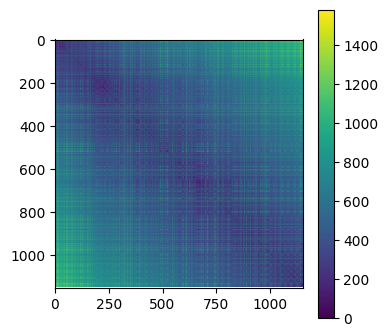

In [90]:
plt.figure(figsize=(4,4), dpi= 100)
plt.imshow(ss)
plt.colorbar()

In [96]:
closest_cells = []
spat_distance_CM = np.zeros([len(new_xs),6],dtype=float)
for ll in range(len(new_xs)):
    nn = np.argsort(ss[ll,:])[np.where((np.sort(ss[ll,:])[0:10]<80)==True)]
    closest_cells.append(nn)
    #for nl in range(len(nn)):
    spat_distance_CM[ll,:] = np.mean(NSCLC_CM_all[nn,0:6],axis=0)    

In [97]:
M_spat = np.log(spat_distance_CM+0.01) # use if needed

In [98]:
df_data = pd.DataFrame(spat_distance_CM)
df_data.to_csv(os.path.join(path_python+'output/count_data/spat_distance_CM.csv'), header=None, index=None)


df_data = pd.DataFrame(M_spat)
df_data.to_csv(os.path.join(path_python + 'output/count_data/M_spat.csv'), header=None, index=None)

df_data = pd.DataFrame(closest_cells)
df_data.to_csv(os.path.join(path_python+'output/count_data/closest_cells.csv'), header=None, index=None)
